In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
from pvlib.solarposition import get_solarposition
import pandas as pd
import json
import itertools
import os

# Brunger Hooper model
Brunger Hooper model is a model to calculate the radiation coming from any sky segment at any point in time. The model was published here: https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=93f59805f64fd372d7ce5e18addbeadcc846de6b


In [2]:
#constants for k=0.35, k_t=0.55, as explained in the paper
A0=.3006
A1=-.2172
A2=4.5443
A3=4.266
DIFFUSE_IRRADIANCE = 1000
# Define the coordinate box. For each sample from this box, one averaged irradiance json is calculated
LATITUDE_MIN, LATITUDE_MAX = 47, 55
LONGITUDE_MIN, LONGITUDE_MAX = 6, 16
LATITUDE_SAMPLES, LONGITUDE_SAMPLES = 9, 11 
# Divide the sky into PHI_SAMPLES * THETA_SAMPLES segments
PHI_SAMPLES = 20
THETA_SAMPLES = 20
# Number of random sun positions used for averaging 
# (Note that night times are filtered out, so the final average will be roughly 0.5* NUMBER_SUN_POSITIONS)
# Choose large values > 1e5 if results should be used further
NUMBER_SUN_POSITIONS = int(1e5)


In [3]:
def sky_radiance(theta, phi, theta_sun, phi_sun, A0=A0, A1=A1, A2=A2, A3=A3, DIFFUSE_IRRADIANCE=DIFFUSE_IRRADIANCE):
    #equation 1 from paper
    psi = np.arccos(np.sin(theta)*np.sin(theta_sun)*np.cos(phi-phi_sun)+np.cos(theta)*np.cos(theta_sun))
    # equation 2 from paper
    I1 = (1+np.exp(-1*A3*np.pi/3))/(A3**2+4)
    I2 = 1-2*(1-np.exp(-A3*np.pi)/np.pi/A3/(1+np.exp(-1*A3*np.pi/2)))
    I3 = 2*theta_sun*np.sin(theta_sun) - 0.02*np.pi*np.sin(2*theta_sun)
    I=I1 * (np.pi - I2 * I3)

    nominator = A0 + A1*np.cos(theta) + A2*np.exp(-1*A3*psi)
    denominator = np.pi*(A0+2*A1/3) + 2*A2*I
    return DIFFUSE_IRRADIANCE*nominator/denominator

In [4]:
def generate_random_sunpositions(N, lat, lon):
    def generate_random_timeseries(N):
        start = '2022-01-01'
        end = '2022-12-31'
        start_u = pd.to_datetime(start).value // 10**9
        end_u = pd.to_datetime(end).value // 10**9
        random_integers = np.random.randint(low=start_u, high=end_u, size=N)
        random_dates = pd.to_datetime(random_integers, unit='s')        
        return pd.Series(random_dates)


    time = generate_random_timeseries(N)
    positions = get_solarposition(time, latitude=lat, longitude=lon)
    positions_day = pd.DataFrame(positions.loc[positions['apparent_elevation'] > 0, :])
    positions_day["apparent_zenith_rad"] = positions_day["apparent_zenith"]/90*np.pi/2
    positions_day["azimuth_rad"] = positions_day["azimuth"]/360*np.pi*2
    return positions_day["apparent_zenith_rad"].to_numpy(), positions_day["azimuth_rad"].to_numpy()

In [5]:
def create_irradiance_json(lat, lon):
    phi = np.linspace(0, 2 * np.pi, PHI_SAMPLES)
    theta = np.linspace(0, 0.5 * np.pi, THETA_SAMPLES)
    Phi, Theta = np.meshgrid(phi, theta)

    Radiance = np.zeros_like(Phi)
    sun_positions = generate_random_sunpositions(NUMBER_SUN_POSITIONS, lat, lon)

    for i in range(len(sun_positions[0])):
        theta_sun, phi_sun = sun_positions[0][i], sun_positions[1][i]
        Radiance += sky_radiance(theta=Theta, phi=Phi, theta_sun=theta_sun, phi_sun=phi_sun)
    Radiance /= len(sun_positions[0])

    data = [
        {
            "theta": round(float(t), 2),
            "phi": round(float(p), 2),
            "radiance": round(float(r), 2)
        }
        for t, p, r in zip(Theta.ravel(), Phi.ravel(), Radiance.ravel())
    ]

    combined_json = {
        "metadata": {
            "description": "Annual averaged diffuse solar irradiance values for the sky over a viewing point in spherical coordinates (theta, phi) using the BrungerHooper Algorithm. The coordinates of the viewing point are given by the file name.",
            "latitude": lat,
            "longitude": lon,
            "samples_phi": PHI_SAMPLES,
            "samples_theta": THETA_SAMPLES
        },
        "data": data
    }

    json_str = json.dumps(combined_json, indent=4)  # Using indent for better readability
    directory = f"irradiance/{lat}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(f"{directory}/{lon}.json", "w") as file:
        file.write(json_str)

In [6]:
import concurrent.futures

latitudes = np.linspace(LATITUDE_MIN, LATITUDE_MAX, LATITUDE_SAMPLES) 
longitudes = np.linspace(LONGITUDE_MIN, LONGITUDE_MAX, LONGITUDE_SAMPLES)


# Single threaded implementation
```
for lat in latitudes:
    for lon in longitudes:
        print(lat,lon)
        create_irradiance_json(lat, lon)
```

In [7]:
def create_files_parallel():
    import concurrent.futures
    import os
    num_workers = os.cpu_count()-1  # Fetch the number of logical CPUs available
    if num_workers is None:  # If for any reason os.cpu_count() fails
        num_workers = 4  # Default to 4 workers
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        # Create a list of tasks
        futures = [executor.submit(create_irradiance_json, lat, lon) for lat in latitudes for lon in longitudes]
        # Optionally, you can handle the completion of each future as follows:
        for future in concurrent.futures.as_completed(futures):
            # This will raise an exception if the function threw one
            future.result()
            
create_files_parallel()

In [8]:

def read_irradiance_json(lat, lon):
    filepath = f"irradiance/{lat}/{lon}.json"
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"No data found for the specified coordinates: {lat}, {lon}")
    
    with open(filepath, 'r') as file:
        data = json.load(file)
    
    # Extract the data part from the JSON
    irradiance_data = data['data']
    
    # Determine the dimensions of the Theta and Phi arrays
    samples_phi = data['metadata']['samples_phi']
    samples_theta = data['metadata']['samples_theta']
    
    # Initialize the arrays
    Phi = np.zeros((samples_theta, samples_phi))
    Theta = np.zeros((samples_theta, samples_phi))
    Radiance = np.zeros((samples_theta, samples_phi))
    
    # Fill the arrays
    for idx, entry in enumerate(irradiance_data):
        i = idx // samples_phi  # Row index
        j = idx % samples_phi   # Column index
        Theta[i, j] = entry['theta']
        Phi[i, j] = entry['phi']
        Radiance[i, j] = entry['radiance']
    
    return Phi, Theta, Radiance

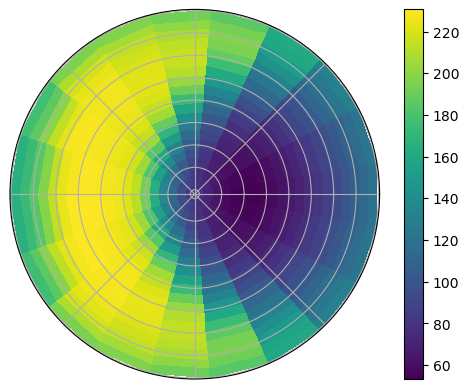

In [9]:
Phi, Theta, Radiance = read_irradiance_json("47.0", "6.0")
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
c = ax.pcolormesh(Phi, Theta, Radiance, shading='auto', norm=Normalize(vmin=Radiance.min(), vmax=Radiance.max()))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.colorbar(c, ax=ax, orientation='vertical')
plt.show()